In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad
from scipy.stats import norm
from scipy.interpolate import interp1d

In [2]:
def uniform(radius):
    while True:
        x = np.random.uniform(-radius, radius, size=4)
        if np.linalg.norm(x) < radius:
            return x


def lattice(N=100, d=4):
    n = N + 1
    z = np.zeros(d)
    a_korobov = 14471.
    for i in np.arange(d):
        z[i] = a_korobov**i % n

    U_lattice = np.zeros((n, d))
    for m in np.arange(n):
        U_lattice[m, :] = ((z * m) / n) % 1


#     U_lattice[0] = np.array([0.01, 0.01, 0.01, 0.01])

    return U_lattice[1:]


def ppf(x):
    return np.array([norm.ppf(xi) for xi in x])


def g(x):
    x_norm = np.linalg.norm(x)
    return (2. * np.pi)**(-2.) * np.exp(-1. / 2. * x_norm**2.)


class E:
    def __init__(self, G, Y, r=3.):
        self.X = G
        self.Y = Y
        self.r = r
        self.M = len(G)

    def knn(self, x, k=5):
        dists = [np.linalg.norm(_ - x) for _ in self.X]
        indices = np.argsort(dists)[:k]
        weights = {}
        if dists[indices[0]] == 0:
            weights[indices[0]] = 1
            for i in indices[1:]:
                weights[i] = 0
        else:
            for _ in indices:
                # weights[_] = 1. / dists[_]**2.
                weights[_] = 1.
            d_sum = np.sum(list(weights.values()))
        return [(i, weights[i] / d_sum) for i in np.argsort(dists)[:k]]

    def f_reg(self, x):
        #         if np.linalg.norm(x) > self.r:
        #             return 0.
        return np.sum([wi * Y[i] for i, wi in self.knn(x, k=10)])

    def brutal(self, N=1000):
        I = 0
        for _ in range(N):
            x = np.random.rand(4)
            I += self.f_reg(x) + self.f_reg(-x)
        return I / N / 2.

    def HMI(self, N=1000):
        x0 = np.zeros(4)
        I = 0
        for _ in range(N):
            x1 = x0 + uniform(self.r / 4.)
            if np.random.rand() < g(x1) / g(x0):
                x0 = x1
            I += self.f_reg(x0) + self.f_reg(-x0)
        return I / N / 2.

    def QMC(self):
        X1 = lattice(N=5000)
        G1 = np.array([ppf(x) for x in X1])
        Y1 = [res.f_reg(x) for x in G1]
        return np.mean(Y1)

    def final(self):
        return np.mean([self.HMI() for _ in range(10)])

In [24]:
def f(x):
    #     x_norm = np.linalg.norm(x)
    #     if x_norm == 0:
    #         return 1.
    return np.max(np.abs(x))


M = 10000
X = lattice(N=M, d=4)
G = np.array([ppf(x) for x in X])
Y = [f(x) for x in G]
dY = 1.96 * np.std(Y) / np.sqrt(M)
print(np.mean(Y), dY)

1.464850077502808 0.011130544272578985


In [3]:
C = [1.]


def c(k):
    if k == 0:
        return 1

    s = 0
    for i in range(k):
        s += C[i] * C[k - i - 1] / (i + 1.) / (2. * i + 1.)
    return s


def a(k):
    return C[k] / (2. * k + 1.)

In [16]:
C

[1.0]

In [4]:
for i in range(1,100):
    C.append(c(i))

In [7]:
len(C)

100

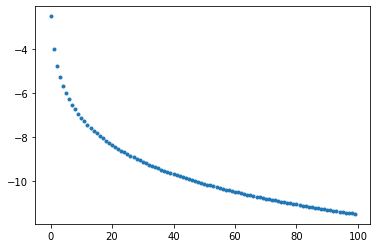

In [12]:
n = 10
A = [
    np.log(a(k) * (np.sqrt(np.pi) / 2.)**(2. * k + 1.) / (2. * k + n + 1.))
    for k in range(len(C))
]

fig, ax = plt.subplots()
ax.plot(A, ".")
plt.show()

In [25]:
def In_fake(n):
    s = 0
    for k in range(20):
        s += a(k) * (np.sqrt(np.pi) / 2.)**(2. * k + 1.) / (2. * k + n + 1.)
    s *= n * np.sqrt(2.)
    return s

In [40]:
12 / np.pi**1.5 * np.arctan(2**(-0.5))

1.3263867552786095

In [4]:
8 * np.sqrt(2) / np.pi**2 * 23 / 18

1.4647400966408215

In [28]:
In_fake(3)

1.3034382318051487

In [15]:
X = lattice()
G = np.array([ppf(x) for x in X])
Y = [f(x) for x in G]
dY = 1.96 * np.std(Y) / 10.
print(np.mean(Y), dY)
res = E(G, Y)
print(res.QMC())

3.6910411750310588 0.400736273160822
2.8195047641459454


In [38]:
0.7/2.4

0.2916666666666667

2.3100129216746796


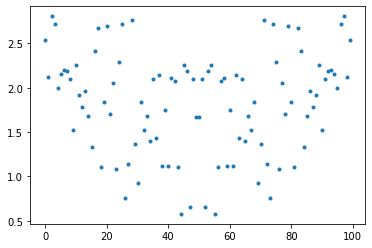

In [80]:
# X1 = lattice(n=1000)
# G1 = np.array([ppf(x) for x in X1])
# Y1 = [res.f_reg(x) for x in G1]

fig, ax = plt.subplots()
# ax.plot(G[:, 3], Y, ".")
# ax.plot(G1[:, 0], Y1, "r-")
ax.plot([np.linalg.norm(x) for x in G], ".")

# ax.set_aspect(1)
plt.show()

In [53]:
f_0 = interp1d(G[:, 3], Y, kind='cubic', bounds_error=False, fill_value=0.)

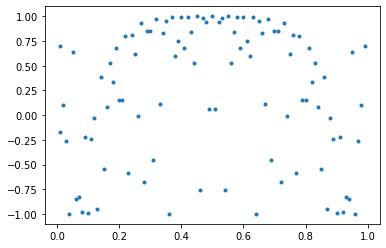

In [61]:
# Xt = np.linspace(-0.1, 0.1, 1000)
# Yt = [f_0(_) for _ in Xt]

fig, ax = plt.subplots()
ax.plot(X[:, 3], Y, ".")
# ax.plot(Xt, Yt, "--")
# ax.plot(G1[:, 0], Y1, "r-")
# ax.plot([np.linalg.norm(x) for x in G], ".")

# ax.set_aspect(1)
plt.show()

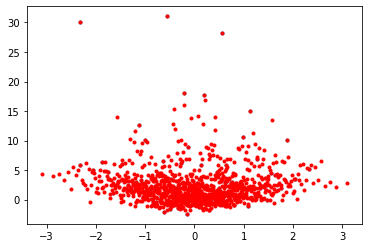

In [33]:
fig, ax = plt.subplots()
ax.plot(G[:, 1], Y, ".")
ax.plot(G1[:, 1], Y1, "r.")
# ax.plot([np.linalg.norm(x) for x in G], ".")

# ax.set_aspect(1)
plt.show()

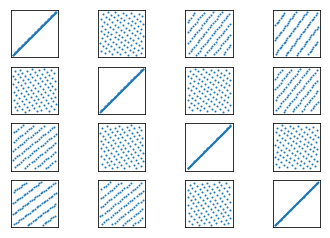

In [4]:
d = 4
U_lattice = lattice()

plt.close('all')
fig = plt.figure('Scatterplot of lattice points')
for i in np.arange(d):
    for j in np.arange(d):
        ax = plt.subplot(d, d, i * (d) + j + 1)
        plt.scatter(U_lattice[:, i], U_lattice[:, j], 1)
        plt.tick_params(axis='both',
                        left='off',
                        top='off',
                        right='off',
                        bottom='off',
                        labelleft='off',
                        labeltop='off',
                        labelright='off',
                        labelbottom='off')
        ax.set_aspect(1)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
# plt.tight_layout()
fig.savefig("lattice.eps", format="eps", dpi=1000)
plt.show()

In [3]:
print(lattice())

[[0.00990099 0.27722772 0.76237624 0.34653465]
 [0.01980198 0.55445545 0.52475248 0.69306931]
 [0.02970297 0.83168317 0.28712871 0.03960396]
 [0.03960396 0.10891089 0.04950495 0.38613861]
 [0.04950495 0.38613861 0.81188119 0.73267327]
 [0.05940594 0.66336634 0.57425743 0.07920792]
 [0.06930693 0.94059406 0.33663366 0.42574257]
 [0.07920792 0.21782178 0.0990099  0.77227723]
 [0.08910891 0.4950495  0.86138614 0.11881188]
 [0.0990099  0.77227723 0.62376238 0.46534653]
 [0.10891089 0.04950495 0.38613861 0.81188119]
 [0.11881188 0.32673267 0.14851485 0.15841584]
 [0.12871287 0.6039604  0.91089109 0.5049505 ]
 [0.13861386 0.88118812 0.67326733 0.85148515]
 [0.14851485 0.15841584 0.43564356 0.1980198 ]
 [0.15841584 0.43564356 0.1980198  0.54455446]
 [0.16831683 0.71287129 0.96039604 0.89108911]
 [0.17821782 0.99009901 0.72277228 0.23762376]
 [0.18811881 0.26732673 0.48514851 0.58415842]
 [0.1980198  0.54455446 0.24752475 0.93069307]
 [0.20792079 0.82178218 0.00990099 0.27722772]
 [0.21782178 